# Can we use the Federal Prime Lending Rate to predict Mutual Fund Performance?

In [5]:
import yfinance as yf
import pandas as pd
import requests
import pickle
from bs4 import BeautifulSoup
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts

import warnings 


%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Yahoo Finance Data on the XLV Fund

In [6]:
xlv = yf.Ticker('XLV')
xlv_hist = xlv.history(period = 'max', actions = False)
xlv_hist['Change'] = xlv_hist['Close'] - xlv_hist['Open']
xlv_hist['Volume'] = xlv_hist.Volume.astype('float64')
xlv_hist.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-12-22,18.41,18.60,18.41,18.58,5700.0,0.17
1998-12-23,18.69,18.99,18.69,18.99,18100.0,0.30
1998-12-24,19.02,19.11,18.94,19.11,4900.0,0.09
1998-12-28,19.05,19.11,18.83,18.83,15500.0,-0.22
1998-12-29,18.83,19.25,18.83,19.25,5300.0,0.42


In [7]:
xlv_hist = xlv_hist.iloc[::-1]

In [8]:

xlv_hist_monthly = xlv_hist['Close'].resample('MS')
xlv_monthly_mean = pd.DataFrame(xlv_hist_monthly.mean())

xlv_monthly_mean.reindex(index=xlv_monthly_mean.index[::-1])

,Close
Date,
2020-01-01,101.695000
2019-12-01,100.354762
2019-11-01,95.596500
2019-10-01,90.148696
2019-09-01,89.694500
...,...
1999-04-01,21.752857
1999-03-01,20.773913
1999-02-01,20.173684


<Figure size 1152x648 with 0 Axes>

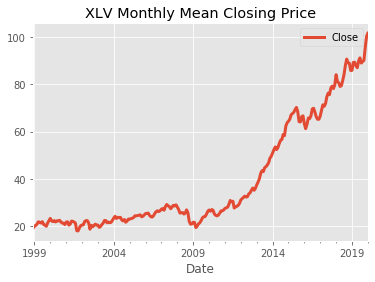

In [9]:
plt.style.use('ggplot')
fig = plt.figure(figsize = (16,9))
xlv_monthly_mean.plot(linewidth = 3, label = 'Closing Price')
plt.title('XLV Monthly Mean Closing Price')
plt.legend()
plt.show()

#There is an upwards Trend

## Perform a Seasonal Decomposition to check for trends, seasonality, and residual distribution

In [10]:


from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(xlv_monthly_mean))

In [11]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

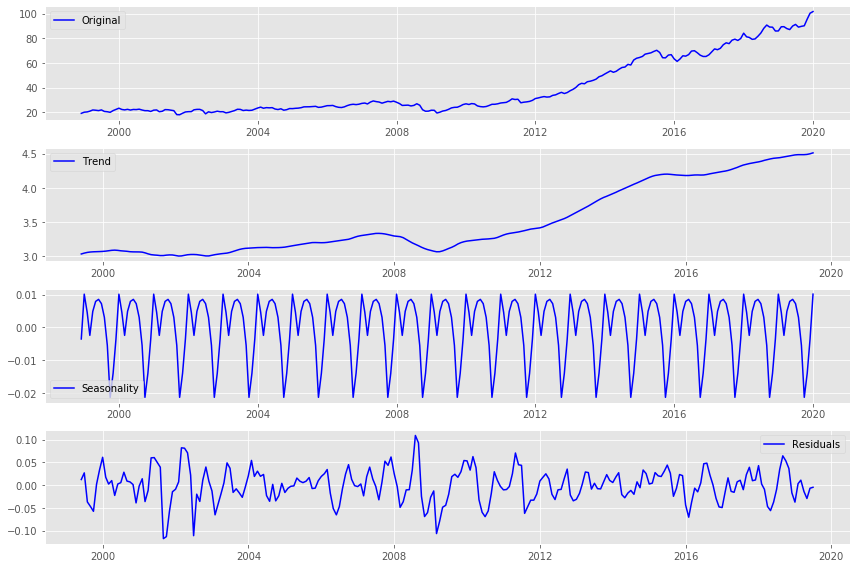

In [12]:
# Original Monthly Mean 
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(xlv_monthly_mean, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

In [13]:
#check stationarity
def stationarity_check(TS):
    
    from statsmodels.tsa.stattools import adfuller
    rolmean = TS.rolling(window = 12, center = False).mean()
    rolstd = TS.rolling(window = 12, center = False).std()
    
    dftest = adfuller(TS)
    
    fig = plt.figure(figsize = (16,9))
    orig = plt.plot(TS, color = 'b', label = 'original')
    mean = plt.plot(rolmean, color = 'r', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    print('Results of Dickey-Fuller Test')
    
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)
    
    return None

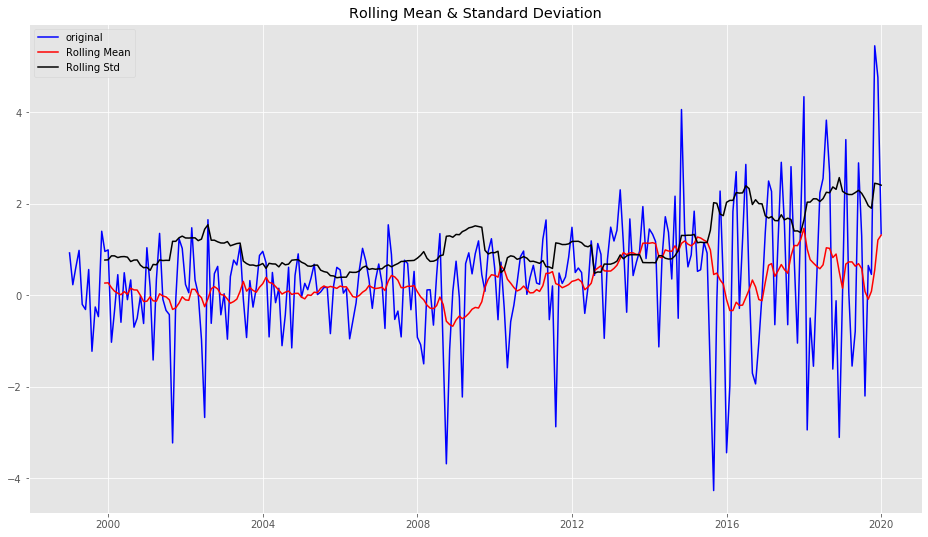

Results of Dickey-Fuller Test
Test Statistic                -1.143664e+01
p-value                        6.324298e-21
#Lags Used                     1.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


In [14]:
#best (first order)
xlv_differenced_mean = xlv_monthly_mean.diff(periods = 1).dropna()
stationarity_check(xlv_differenced_mean.Close)

#### P-val = 7.32e-11 -->  Reject the null hypothesis that the data is not stationary

## ARMA: Auto-Regressive - PACF

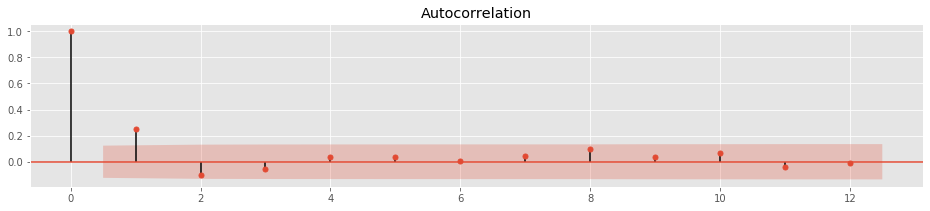

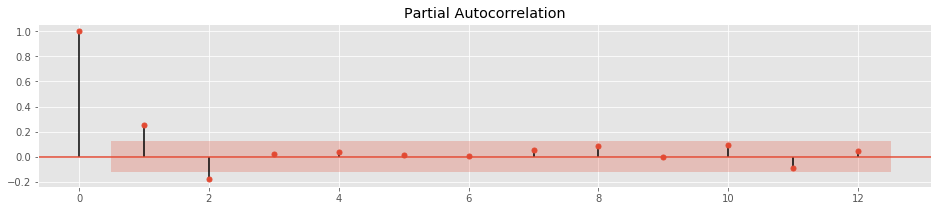

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize = (16,3))
plot_acf(xlv_differenced_mean, ax = ax, lags = 12);

fig, ax = plt.subplots(figsize = (16,3))
plot_pacf(xlv_differenced_mean, ax=ax, lags = 12);

In [16]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean, trend='n', order=(1,1,2), seasonal_order=(1,1,2,12))
res = mod.fit()
res.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -408.739
Date:                            Tue, 07 Jan 2020   AIC                            831.477
Time:                                    10:03:59   BIC                            855.871
Sample:                                12-01-1998   HQIC                           841.305
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2917      0.534      0.547      0.585      -0.754       1.338
ma.L1          0.0051      0.533      0.010      0.992      -1.039       1.049
ma.L2         -0.1963      0.185     -1.064      0.287      -0.558       0.165
ar.S.L12      -0.9993      0.070    -14.196      0.000      -1.137      -0.861
ma.S.L12       0.1501      0.503      0.298      0.766      -0.837       1.137
ma.S.L24      -0.8320      0.449     -1.852      0.064      -1.712       0.049
sigma2         1.5765      0.688      2.290      0.022       0.227       2.926
===================================================================================
Ljung-Box (Q):                       30.46   Jarque-Bera (JB):                58.28
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               4.42   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean, trend='n', order=(1,1,1), seasonal_order=(1,1,1,12))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  254
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -412.097
Date:                            Tue, 07 Jan 2020   AIC                            834.193
Time:                                    10:03:59   BIC                            851.617
Sample:                                12-01-1998   HQIC                           841.213
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2043      0.172     -1.188      0.235      -0.541       0.133
ma.L1          0.5209      0.161      3.243      0.001       0.206       0.836
ar.S.L12      -0.0762      0.074     -1.026      0.305      -0.222       0.069
ma.S.L12      -0.8341      0.061    -13.629      0.000      -0.954      -0.714
sigma2         1.6750      0.126     13.295      0.000       1.428       1.922
===================================================================================
Ljung-Box (Q):                       33.07   Jarque-Bera (JB):                50.48
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               4.38   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
xlv_monthly_mean['Close_P'] = res.predict(start = 225, end = 254, dynamic = False)

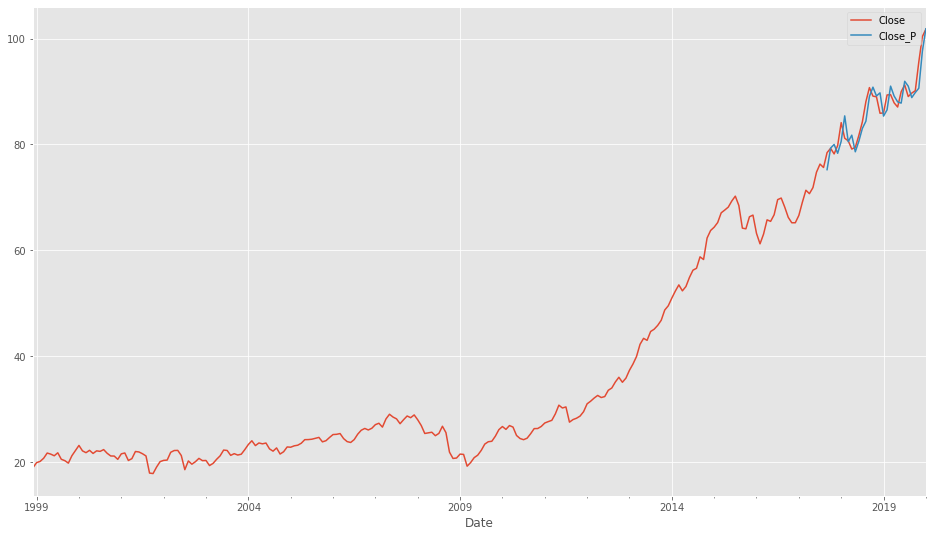

In [15]:
xlv_monthly_mean[['Close', 'Close_P']].plot(figsize = (16,9))

In [16]:
xlv_monthly_mean.head()

,Close,Close_P
Date,,
1998-12-01,19.021429,NaN
1999-01-01,19.944737,NaN
1999-02-01,20.173684,NaN
1999-03-01,20.773913,NaN
1999-04-01,21.752857,NaN


In [17]:
from dateutil.relativedelta import relativedelta
import datetime

start = datetime.datetime.strptime("2020-02-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index = date_list, columns = xlv_monthly_mean.columns)
xlv_monthly_mean = pd.concat([xlv_monthly_mean, future])

In [18]:
xlv_monthly_mean.tail()

,Close,Close_P
2020-09-01,NaN,NaN
2020-10-01,NaN,NaN
2020-11-01,NaN,NaN
2020-12-01,NaN,NaN
2021-01-01,NaN,NaN


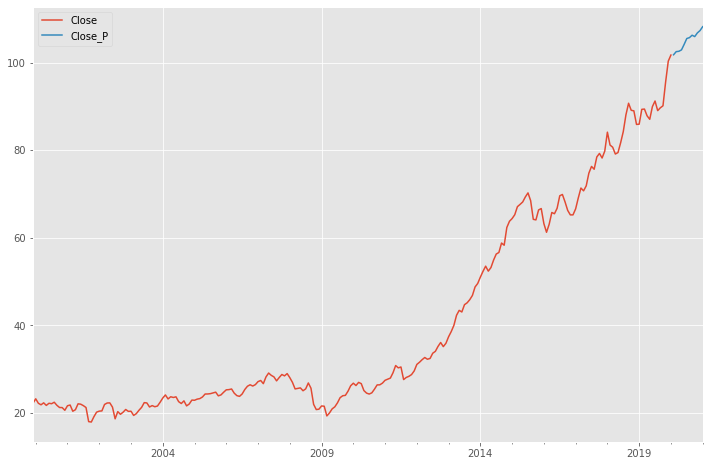

In [19]:
xlv_monthly_mean['Close_P'] = res.predict(start = 254, end = 266, dynamic = True)
xlv_monthly_mean[['Close', 'Close_P']].iloc[-254:].plot(figsize=(12,8))
plt.savefig('XLV_predict_future.png', bbox_inches = 'tight')


### Dynamic Forecasting

In [20]:
prediction = res.get_forecast(steps = 36)
pred_conf = prediction.conf_int()


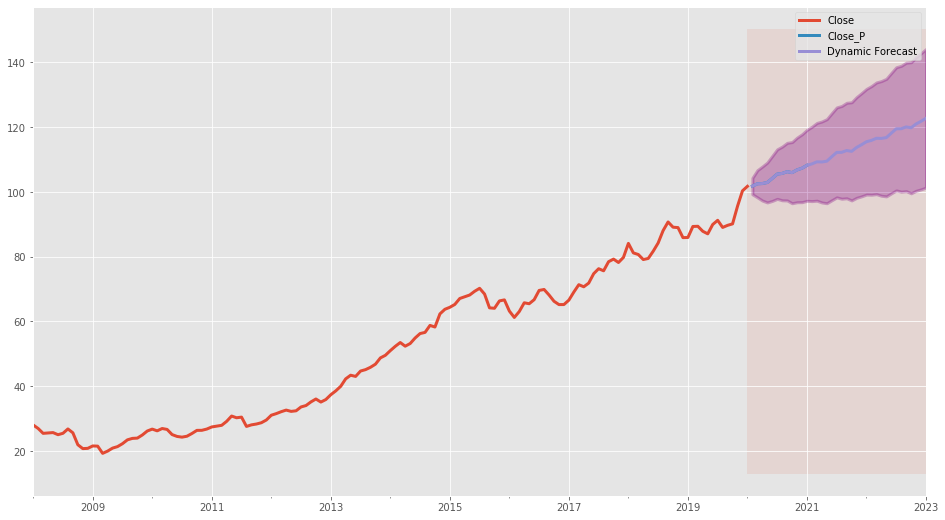

In [21]:
ax = xlv_monthly_mean['2008':].plot(label = 'Observed', figsize = (16,9), linewidth = 3)
prediction.predicted_mean.plot(label = 'Dynamic Forecast', ax=ax, linewidth = 3)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:,0],
                pred_conf.iloc[:,1], color = 'purple', alpha = .3, linewidth = 3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), pd.to_datetime('2023-01-01'), alpha=.1, zorder=-1)

plt.legend()
plt.show()

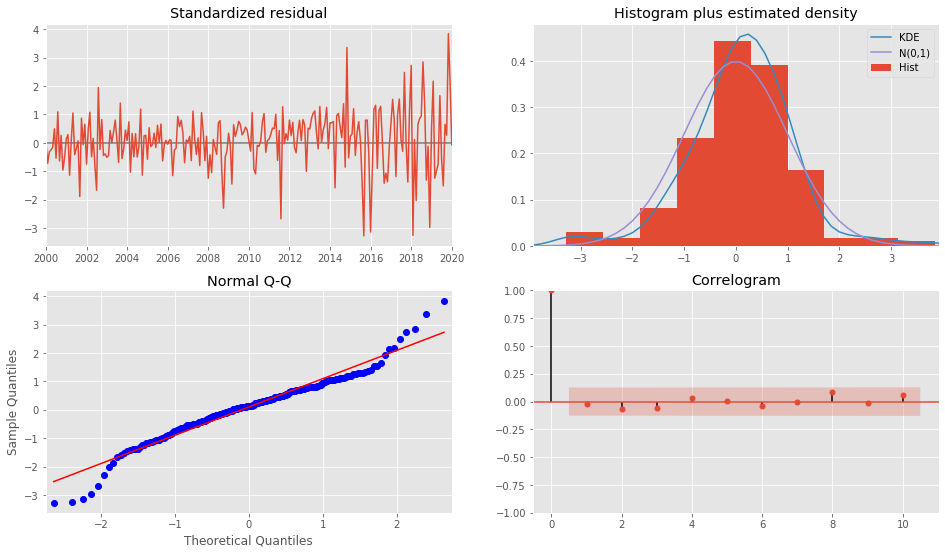

In [22]:
res.plot_diagnostics(figsize = (16,9));

### Auto-ARIMA

In [23]:
# Define the p, d and q parameters to take any value between 0 and 2
import itertools
p = d = q = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))
print(pdq)

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
print(pdqs)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 2, 0, 12), (1, 2, 1, 12), (1, 2, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 2, 0, 12), (2, 2, 1, 12), (2, 2, 2, 12)]


In [24]:

warnings.filterwarnings(action='once')
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(xlv_monthly_mean.Close, 
                                            order = comb, 
                                            seasonal_order = combs, 
                                            enforce_stationarity = False, 
                                            enforce_invertability = False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {} : AIC Calculated = {}'.format(comb, combs, output.aic))
        except:
            continue

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


ARIMA (0, 0, 0) x (0, 0, 0, 12) : AIC Calculated = 2654.6576813977717
ARIMA (0, 0, 0) x (0, 0, 1, 12) : AIC Calculated = 2278.284214556873
ARIMA (0, 0, 0) x (0, 0, 2, 12) : AIC Calculated = 1979.4399127467682
ARIMA (0, 0, 0) x (0, 1, 0, 12) : AIC Calculated = 1574.10785305569
ARIMA (0, 0, 0) x (0, 1, 1, 12) : AIC Calculated = 1458.1887784536239
ARIMA (0, 0, 0) x (0, 1, 2, 12) : AIC Calculated = 1377.5344913988479
ARIMA (0, 0, 0) x (0, 2, 0, 12) : AIC Calculated = 1476.4859396484644
ARIMA (0, 0, 0) x (0, 2, 1, 12) : AIC Calculated = 1333.04635685237
ARIMA (0, 0, 0) x (0, 2, 2, 12) : AIC Calculated = 1270.1325277045994
ARIMA (0, 0, 0) x (1, 0, 0, 12) : AIC Calculated = 1435.180049085256
ARIMA (0, 0, 0) x (1, 0, 1, 12) : AIC Calculated = 1430.1225504210986
ARIMA (0, 0, 0) x (1, 0, 2, 12) : AIC Calculated = 1370.8888482263617
ARIMA (0, 0, 0) x (1, 1, 0, 12) : AIC Calculated = 1434.9048567516002
ARIMA (0, 0, 0) x (1, 1, 1, 12) : AIC Calculated = 1402.8931988609525
ARIMA (0, 0, 0) x (1, 1, 2

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (2, 0, 2, 12) : AIC Calculated = 1357.4360546685
ARIMA (0, 0, 0) x (2, 1, 0, 12) : AIC Calculated = 1359.4523503736955
ARIMA (0, 0, 0) x (2, 1, 1, 12) : AIC Calculated = 1341.478775768263
ARIMA (0, 0, 0) x (2, 1, 2, 12) : AIC Calculated = 1339.450632989973
ARIMA (0, 0, 0) x (2, 2, 0, 12) : AIC Calculated = 1285.2256477428512
ARIMA (0, 0, 0) x (2, 2, 1, 12) : AIC Calculated = 1278.13881023528
ARIMA (0, 0, 0) x (2, 2, 2, 12) : AIC Calculated = 1274.7704264547817
ARIMA (0, 0, 1) x (0, 0, 0, 12) : AIC Calculated = 2312.1442630316437


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA (0, 0, 1) x (0, 0, 1, 12) : AIC Calculated = 1954.1886654675545
ARIMA (0, 0, 1) x (0, 0, 2, 12) : AIC Calculated = 1678.3605386515565
ARIMA (0, 0, 1) x (0, 1, 0, 12) : AIC Calculated = 1287.8573761162252
ARIMA (0, 0, 1) x (0, 1, 1, 12) : AIC Calculated = 1200.7110641543459
ARIMA (0, 0, 1) x (0, 1, 2, 12) : AIC Calculated = 1142.7659649305313
ARIMA (0, 0, 1) x (0, 2, 0, 12) : AIC Calculated = 1253.735357177532
ARIMA (0, 0, 1) x (0, 2, 1, 12) : AIC Calculated = 1106.302641916877
ARIMA (0, 0, 1) x (0, 2, 2, 12) : AIC Calculated = 1054.2618478077673
ARIMA (0, 0, 1) x (1, 0, 0, 12) : AIC Calculated = 1184.3306862968468
ARIMA (0, 0, 1) x (1, 0, 1, 12) : AIC Calculated = 1183.0616319962855
ARIMA (0, 0, 1) x (1, 0, 2, 12) : AIC Calculated = 1133.2461178246772
ARIMA (0, 0, 1) x (1, 1, 0, 12) : AIC Calculated = 1198.113843717637
ARIMA (0, 0, 1) x (1, 1, 1, 12) : AIC Calculated = 1164.1303118183125
ARIMA (0, 0, 1) x (1, 1, 2, 12) : AIC Calculated = 1109.6032890819697
ARIMA (0, 0, 1) x (1, 2

In [25]:
ans_df = pd.DataFrame(ans, columns = ['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (2, 2, 2)
pdqs    (1, 1, 2, 12)
aic           745.377
Name: 716, dtype: object

In [32]:
Auto_ARIMA = sm.tsa.statespace.SARIMAX(xlv_monthly_mean.Close,
                                       order = (2,2,2),
                                       seasonal_order = (1,1,2,12),
                                       enforce_stationarity = False,
                                       enforce_invertability = False)
output_auto = Auto_ARIMA.fit()
print(output_auto.summary().tables[1])
output_auto.summary()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1721      0.302      0.570      0.569      -0.420       0.764
ar.L2         -0.1996      0.122     -1.634      0.102      -0.439       0.040
ma.L1         -0.8787      0.325     -2.702      0.007      -1.516      -0.241
ma.L2         -0.1182      0.330     -0.358      0.720      -0.765       0.529
ar.S.L12      -0.8408      0.146     -5.777      0.000      -1.126      -0.556
ma.S.L12      -0.1143      0.173     -0.662      0.508      -0.453       0.224
ma.S.L24      -0.6896      0.166     -4.142      0.000      -1.016      -0.363
sigma2         1.6640      0.239      6.958      0.000       1.195       2.133


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  266
Model:             SARIMAX(2, 2, 2)x(1, 1, 2, 12)   Log Likelihood                -364.689
Date:                            Mon, 06 Jan 2020   AIC                            745.377
Time:                                    22:38:58   BIC                            772.706
Sample:                                12-01-1998   HQIC                           756.407
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1721      0.302      0.570      0.569      -0.420       0.764
ar.L2         -0.1996      0.122     -1.634      0.102      -0.439       0.040
ma.L1         -0.8787      0.325     -2.702      0.007      -1.516      -0.241
ma.L2         -0.1182      0.330     -0.358      0.720      -0.765       0.529
ar.S.L12      -0.8408      0.146     -5.777      0.000      -1.126      -0.556
ma.S.L12      -0.1143      0.173     -0.662      0.508      -0.453       0.224
ma.S.L24      -0.6896      0.166     -4.142      0.000      -1.016      -0.363
sigma2         1.6640      0.239      6.958      0.000       1.195       2.133
===================================================================================
Ljung-Box (Q):                       30.52   Jarque-Bera (JB):                67.71
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               4.64   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""